# Assignment 2

***

## Question 1: Neural Codes & Nearest Neighbor retrieval (7.5pt)
The Caltech101 dataset consists of images of 101 different objects. In this question you will develop an image retrieval system using image representations (neural codes) learned with a deep convolutional neural network and a given distance metric.

In the tasks below you will need to implement the following steps:

* Retrieval for $n$ selected (distinct) query images from the dataset
    * For each query image, obtain the 5 most similar images (excluding the query image itself!)
* Evaluation of the quality of the retrieval 
    * The Caltech101 images are annotated with their object class. Use these annotations to evaluate the accuracy of the retrieval task.
    * For each query image, count the number of images whose class corresponds to the one from the query. The score of the retrieval for that image then ranges between:
        * **5** *all* retrieved images' classes agree with the query image class
        * **0** *none* of the images' classes agree with the query image class
    * Compute the average of all $n$ queries

***

### Task 1.1:  Neural codes image retrieval
**a)** Implement the retrieval task and evaluate the results for $n=200$ images. Use the provided VGG16 network pre-trained on ImageNet to compute "neural codes" and L2-distance. Specifically use the codes produces by the following layers of the model: 
1. the "fc1"-layer
2. the "fc2"-layer

Provide the retrieval evaluation scores for both tasks.

In [1]:
# you'll need these imports:
from sklearn.neighbors import NearestNeighbors
import os
import numpy as np
import pickle

In [2]:
# NOTE: you will first need to apply some changes to "Practical-3.3.0_preprocess-caltech101.ipynb" and run it
#       to obtain a pickle file with "fc1"-features. You don't need to show these changes here.


# make random selection of n query images/indices, the same for all experiments
n = 200
n_examples = 8677  # the dataset has 8677 images
indices = np.random.choice(range(n_examples), size=n, replace=False)

# iterate over two data representations (make sure these two files exist in the "data" subfolder first)
for datapath in ("caltech101_VGG16_fc1.p", "caltech101_VGG16_fc2.p"):
    # load the dataset
    with open(os.path.join("data", datapath), "rb") as f:
        X_fc, y, X_paths, classes = pickle.load(f)


    # === SOLUTION: ===
    # insert code here

FileNotFoundError: [Errno 2] No such file or directory: 'data\\caltech101_VGG16_fc1.p'

***

**b)** Which representation ("neural code") provided better features for the given retrieval task? 
Justify your answer and discuss possible reasons for the observed results. Relate your answer to the conclusions in the paper "Neural Codes for Image Retrieval".

**Answer:**

*=== write your answer here ===*

***

### Task 1.2: Detailed evaluation
**a)** The retrieval scores can vary from one query image to another. Some images are quite representative and for them retrieval works well, some are not so much.
For the same retrieval task given above using "fc2"-features, find (if possible) six query images such that they range from excellent to poor retrieval performance. More specifically find example query images that result in query scores of exactly 0, 1, 2, 3, 4, and 5.

Visualise the six (or less) resulting query images.

In [2]:
# you'll need these extra imports:
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

c:\users\illia\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
# load the dataset
datapath = "caltech101_VGG16_fc2.p"
with open(os.path.join("data", datapath), "rb") as f:
    X_fc, y, X_paths, classes = pickle.load(f)

# you can use this simple function to visualise an image, given a filepath
def show_img(filepath):
    img = image.load_img(filepath, target_size=(224,224))
    plt.imshow(img)
    plt.axis("off")
    plt.show()
# example usage given some index < 8677:
#index = 254
#show_img(X_paths[index])


# === SOLUTION: ===
# insert code here

FileNotFoundError: [Errno 2] No such file or directory: 'data\\caltech101_VGG16_fc2.p'

***

**b)** Looking at the results, what can you say about the "types" of images that obtain good retrieval scores compared to those obtaining poor retrieval scores? Give an explanation and possible solution(s).

(*HINT: How did we obtain data representations for similarity measures?*)

**Answer:**

*=== write your answer here ===*

***

### Task 1.3: Subjective evaluation
We will now use the "fc2"-features to do image retrieval for query images from the "BACKGROUND_Google" set from the Caltech101 dataset. These images are not associated to a particular class, so we will evaluate them subjectively instead.

**a)** Find two query images from the "BACKGROUND_Google" class, such that for the first query image relevant/similar images are retrieved (according to your own definition of relevancy/similarity), and for the second image mainly irrelevant/dissimilar images are retrieved. For each of them, visualise its 5 nearest neighbors in the Caltech101 dataset (*so do NOT retrieve images from the "BACKGROUND_Google" class!*), according to the "fc2-features" and L2-distance.

In [ ]:
# load the BACKGROUND_Google set
with open(os.path.join("data","caltech101_VGG16_fc2_bg.p"), "rb") as f:
    bg_fc2, bg_paths = pickle.load(f)


# === SOLUTION: ===
# insert code here

***

**b)** Motivate your idea of "relevance": why do you consider the results for the first image relevant/similar, and those for the second image irrelevant/dissimilar?

**Answer:**

*=== write your answer here ===*

***

**c)** Explain why you think this retrieval method (nearest neighbor for neural codes from VGG16) performs better on the first image than on the second.

**Answer:**

*=== write your answer here ===*

***

### Task 1.4: Dimensionality reduction

**a)** So far we've been using 4096-dimensional neural codes. This space is however still quite high-dimensional. Apply a dimensionality reduction method and evaluate the effect on the retrieval performance.

* Use PCA to obtain lower-dimensional representations of the Caltech101 data "fc2"-features (try the same compression rates as in Table 2 of the "Neural Codes for Image Retrieval" paper).
* Evaluate the same retrieval task as explained at the start of this question for each of the compression rates/dimensionalities. Report the retrieval scores.

*HINT: See http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html on how to transform a dataset with PCA.*

In [3]:
# import PCA from scikit-learn
from sklearn.decomposition import PCA

In [ ]:
# load the data
datapath = "caltech101_VGG16_fc2.p"
with open(os.path.join("data", datapath), "rb") as f:
    X_fc, y, X_paths, classes = pickle.load(f)
    
# make random selection of n query images/indices, the same for all experiments
n = 200
n_examples = 8677  # the dataset has 8677 images
indices = np.random.choice(range(n_examples), size=n, replace=False)


# === SOLUTION: ===
# insert code here

***

**b)** Discuss your results: how much can you further reduce the dimensionality of the data representations, without affecting the retrieval performance (much)? Compare these results to those from the paper, are your conclusions similar or not?

**Answer:**

*=== write your answer here ===*

***

## Question 2: Fashion-MNIST (12.5pt)
For this question we will work with the "Fashion-MNIST" dataset. This dataset is modelled to have the same specifics as MNIST; it consists of a training set of 60,000 examples, and a test set of 10,000 examples. Each example is a 28x28 greyscale image, associated with a label from one of 10 classes. The images represent various clothing items (as opposed to handwritten digits for MNIST), each class represents a different type of clothing item. The following classes exist:
* 0:	T-shirt/top
* 1:	Trouser
* 2:	Pullover
* 3:	Dress
* 4:	Coat
* 5:	Sandal
* 6:	Shirt
* 7:	Sneaker
* 8:	Bag
* 9:	Ankle boot

In this question we will investigate various ways to model visual similarity for this dataset, in order to perform image retrieval. For more info about the dataset, see https://github.com/zalandoresearch/fashion-mnist.

The dataset can directly be obtained through Keras:

X_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 10)
X_test shape: (10000, 28, 28, 1)
y_test shape: (10000, 10)


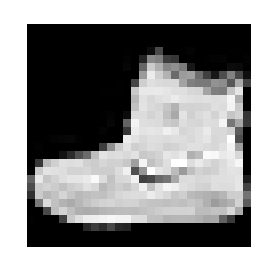

Class: Ankle boot (9)


In [4]:
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras import backend as K

# load the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# properties of the data
img_rows, img_cols, chns = 28, 28, 1
n_classes = 10

# reshape
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], chns, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], chns, img_rows, img_cols)
    input_shape = (chns, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, chns)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, chns)
    input_shape = (img_rows, img_cols, chns)

# normalise
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

# transform labels to one-hot encoding, but also keep original single-digit encoding
y_train_digits = y_train
y_test_digits = y_test
y_train = to_categorical(y_train_digits, n_classes)
y_test = to_categorical(y_test_digits, n_classes)

print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# show an example
example_id = 0  # pick any integer from 0 to 59999 to visualize a training example
example = x_train[example_id].reshape(img_rows, img_cols)
label = y_train[example_id]
label_digit = y_train_digits[example_id]
label_class = classes[label_digit]
plt.matshow(example, cmap="gray")
plt.axis("off")
plt.show()
print("Class: {} ({})".format(label_class, label_digit))

Consider the following situation: We have a fully labelled dataset (the ***labelled set***) of the images from the first 5 classes (t-shirts/tops, trousers, pullovers, dresses, coats). We are then supplied with an unlabelled dataset (the ***retrieval set***) containing the remaining Fashion-MNIST images (sandals, shirts, sneakers, bags, ankle boots) on which we want to be able to perform image retrieval. So we cannot use labels from the retrieval set, since we do not know them (note that in our case we *do* have the labels, but we will only use them for evaluation).

The following code splits the dataset up into two sets representing 5 classes each. Observe that the labelled and the retrieval set have exactly the same size.

In [8]:
# obtain indices of labelled and retrieval sets
indices_train_l = np.argwhere(y_train_digits < 5).flatten()  # indices labelled training set
indices_train_r = np.argwhere(y_train_digits >= 5).flatten()  # indices retrieval training set
indices_test_l = np.argwhere(y_test_digits < 5).flatten()  # indices labelled test set
indices_test_r = np.argwhere(y_test_digits >= 5).flatten()  # indices retrieval test set

# split up train and test set (images and labels)
x_train_l = x_train[indices_train_l]
x_train_r = x_train[indices_train_r]
y_train_l = y_train[indices_train_l]
y_train_r = y_train[indices_train_r]
y_train_digits_l = y_train_digits[indices_train_l]
y_train_digits_r = y_train_digits[indices_train_r]
x_test_l = x_test[indices_test_l]
x_test_r = x_test[indices_test_r]
y_test_l = y_test[indices_test_l]
y_test_r = y_test[indices_test_r]
y_test_digits_l = y_test_digits[indices_test_l]
y_test_digits_r = y_test_digits[indices_test_r]

# labels are now one-hot encoded 10-dimensional vectors, but only the first or last five dimensions are used
# omit unused dimensions to obtain 5-dimensional one-hot encodings
y_train_l = y_train_l[:, :5]
y_train_r = y_train_r[:, 5:]
y_test_l = y_test_l[:, :5]
y_test_r = y_test_r[:, 5:]
# (note that the dimensions of y_train_l/y_test_l do not correspond to those of y_train_r/y_test_r now)

# print the shapes
print(x_train_l.shape)
print(x_train_r.shape)
print(y_train_l.shape)
print(y_train_r.shape)
print(y_train_digits_l.shape)
print(y_train_digits_r.shape)
print(x_test_l.shape)
print(x_test_r.shape)
print(y_test_l.shape)
print(y_test_r.shape)
print(y_test_digits_l.shape)
print(y_test_digits_r.shape)

(30000, 28, 28, 1)
(30000, 28, 28, 1)
(30000, 5)
(30000, 5)
(30000,)
(30000,)
(5000, 28, 28, 1)
(5000, 28, 28, 1)
(5000, 5)
(5000, 5)
(5000,)
(5000,)


***

### Task 2.1: Fashion neural retrieval
**a)** Design an MLP (multilayer perceptron) for classification on the first 5 classes of the Fashion-MNIST dataset (i.e. only use `x_train_l` for training). You may include Dropout and BatchNormalization if needed. Let the last hidden dense layer (before the 5-dimensional output layer) have 128 dimensions. (*HINT: you can use* `name="neural_codes"` *for this layer to make it easier to obtain features from it later.*)

Train it to classify images into their corresponding classes. Make sure that it achieves decent accuracy (at least 90%) on the labelled test set `x_test_l` (show this!). Save the trained model to a ".h5" file. (make sure you're using Keras version 2.1.3!)

In [5]:
# import sequential model and layers
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization

In [78]:
from keras import optimizers
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
mlp = Sequential()
mlp.add(Dense(256, input_shape=input_shape,name="neural_codes_mlp_1"))
#mlp.add(Dropout(0.5))
mlp.add(Dense(128, name="neural_codes_mlp_2"))
#mlp.add(BatchNormalization())
mlp.add(Flatten())
mlp.add(Dense(5, activation='softmax',name="neural_codes_mlp_3"))
mlp.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# === SOLUTION: ===
# insert code here

In [80]:
batch_size = 100
epochs = 20
mlp.fit(x_train_l, y_train_l,batch_size=batch_size,epochs=epochs,validation_split=0.1)

Train on 27000 samples, validate on 3000 samples
Epoch 1/20
27000/27000 [==============================] - 109s 4ms/step - loss: 0.3749 - acc: 0.8691 - val_loss: 0.3420 - val_acc: 0.8720
Epoch 2/20
27000/27000 [==============================] - 110s 4ms/step - loss: 0.3401 - acc: 0.8815 - val_loss: 0.3648 - val_acc: 0.8650
Epoch 3/20
27000/27000 [==============================] - 108s 4ms/step - loss: 0.3367 - acc: 0.8839 - val_loss: 0.3347 - val_acc: 0.8767
Epoch 4/20
27000/27000 [==============================] - 108s 4ms/step - loss: 0.3231 - acc: 0.8861 - val_loss: 0.3230 - val_acc: 0.8893
Epoch 5/20
27000/27000 [==============================] - 108s 4ms/step - loss: 0.3187 - acc: 0.8881 - val_loss: 0.3222 - val_acc: 0.8870
Epoch 6/20
27000/27000 [==============================] - 109s 4ms/step - loss: 0.3139 - acc: 0.8899 - val_loss: 0.3456 - val_acc: 0.8807
Epoch 7/20
27000/27000 [==============================] - 115s 4ms/step - loss: 0.3139 - acc: 0.8893 - val_loss: 0.3120 - v

In [83]:
loss, accuracy = mlp.evaluate(x_test_l, y_test_l, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.35241450238227845
Test accuracy: 0.8754


In [92]:
# create directory if doesn't exist yet
try:
    os.mkdir("assignment2_models")
except(FileExistsError):
    pass

# save the model
mlp.save(os.path.join("assignment2_models", "mlp_fashionmnist_l_lama.h5"))

In [89]:
from keras import optimizers
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
mlp = Sequential()
mlp.add(Dense(512, input_shape=input_shape,name="neural_codes_mlp_1"))
mlp.add(Dense(256, name="neural_codes_mlp_2"))
mlp.add(Dense(128, name="neural_codes_mlp_3"))
mlp.add(Flatten())
mlp.add(Dense(5, activation='softmax',name="neural_codes_mlp_4"))
mlp.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# === SOLUTION: ===
# insert code here

In [90]:
batch_size = 100
epochs = 20
mlp.fit(x_train_l, y_train_l,batch_size=batch_size,epochs=epochs,validation_split=0.1)

Train on 27000 samples, validate on 3000 samples
Epoch 1/20
27000/27000 [==============================] - 391s 14ms/step - loss: 0.4238 - acc: 0.8490 - val_loss: 0.3500 - val_acc: 0.8790
Epoch 2/20
27000/27000 [==============================] - 383s 14ms/step - loss: 0.3444 - acc: 0.8796 - val_loss: 0.3639 - val_acc: 0.8713
Epoch 3/20
27000/27000 [==============================] - 368s 14ms/step - loss: 0.3405 - acc: 0.8793 - val_loss: 0.3387 - val_acc: 0.8793
Epoch 4/20
27000/27000 [==============================] - 368s 14ms/step - loss: 0.3271 - acc: 0.8859 - val_loss: 0.3458 - val_acc: 0.8780
Epoch 5/20
27000/27000 [==============================] - 365s 14ms/step - loss: 0.3168 - acc: 0.8906 - val_loss: 0.3126 - val_acc: 0.8867
Epoch 6/20
27000/27000 [==============================] - 366s 14ms/step - loss: 0.3197 - acc: 0.8871 - val_loss: 0.3348 - val_acc: 0.8753
Epoch 7/20
27000/27000 [==============================] - 366s 14ms/step - loss: 0.3167 - acc: 0.8875 - val_loss: 0.3

In [91]:
loss, accuracy = mlp.evaluate(x_test_l, y_test_l, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.35060056457519534
Test accuracy: 0.8714


In [6]:
from keras import optimizers
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
mlp = Sequential()
mlp.add(Dense(256, input_shape=input_shape))
mlp.add(BatchNormalization())
mlp.add(Dropout(0.5))
mlp.add(Dense(128, name="neural_codes"))
mlp.add(BatchNormalization())
mlp.add(Dropout(0.5))
mlp.add(Flatten())
mlp.add(Dense(5, activation='softmax'))
mlp.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# === SOLUTION: ===
# insert code here


In [9]:
batch_size = 100
epochs = 20
mlp.fit(x_train_l, y_train_l,batch_size=batch_size,epochs=epochs,validation_split=0.1)

Train on 27000 samples, validate on 3000 samples
Epoch 1/20
27000/27000 [==============================] - 499s 18ms/step - loss: 1.9222 - acc: 0.7971 - val_loss: 0.7619 - val_acc: 0.8300
Epoch 2/20
27000/27000 [==============================] - 498s 18ms/step - loss: 1.8267 - acc: 0.8456 - val_loss: 1.5227 - val_acc: 0.8547
Epoch 3/20
27000/27000 [==============================] - 495s 18ms/step - loss: 1.8211 - acc: 0.8574 - val_loss: 1.6092 - val_acc: 0.8743
Epoch 4/20
27000/27000 [==============================] - 497s 18ms/step - loss: 1.8438 - acc: 0.8620 - val_loss: 1.8861 - val_acc: 0.8617
Epoch 5/20
27000/27000 [==============================] - 497s 18ms/step - loss: 1.7364 - acc: 0.8720 - val_loss: 1.7809 - val_acc: 0.8707
Epoch 6/20
27000/27000 [==============================] - 499s 18ms/step - loss: 1.7903 - acc: 0.8689 - val_loss: 1.8281 - val_acc: 0.8700
Epoch 7/20
27000/27000 [==============================] - 498s 18ms/step - loss: 1.7908 - acc: 0.8720 - val_loss: 1.9

In [10]:
loss, accuracy = mlp.evaluate(x_test_l, y_test_l, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.8740189331173995
Test accuracy: 0.8706


In [11]:
# create directory if doesn't exist yet
try:
    os.mkdir("assignment2_models")
except(FileExistsError):
    pass

# save the model
mlp.save(os.path.join("assignment2_models", "mlp_fashionmnist_l_8706.h5"))



***

**b)** Briefly motivate how and why you chose this architecture.

**Answer:**

*=== write your answer here ===*

***

### Task 2.2: Fashion neural retrieval #2
**a)** Design a CNN (convolutional neural network) for classification on the first 5 classes of the Fashion-MNIST dataset (i.e. only use x_train_l for training), consisting of a number of Convolutions with Max-Pooling, followed by one or more Dense layers. You may use Dropout and BatchNormalization to improve generalization and training speed. Let the last hidden dense layer (before the 5-dimensional output layer) have 128 dimensions. (*HINT: you can use* `name="neural_codes"` *for this layer to make it easier to obtain features from it later.*)

Train the CNN to classify images into their corresponding classes. Make sure that it achieves decent accuracy (at least 94%) on the test set `x_test_l` (show this!). Save the trained model to a ".h5" file. (make sure you're using Keras version 2.1.3!)

In [1]:
# import additional layers
from keras.layers import Conv2D, MaxPooling2D

c:\users\illia\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [98]:
cnn = Sequential()

cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape,name="neural_codes_cnn_1"))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu',name="neural_codes_cnn_2"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
cnn.add(Dense(128, name="neural_codes_cnn_3"))
cnn.add(Flatten())
cnn.add(Dense(5, activation='softmax',name="neural_codes_cnn_4"))
cnn.summary()
cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# === SOLUTION: ===
# insert code here

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
neural_codes_cnn_1 (Conv2D)  (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_16 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
dropout_31 (Dropout)         (None, 26, 26, 32)        0         
_________________________________________________________________
neural_codes_cnn_2 (Conv2D)  (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 12, 12, 64)        256       
_________________________________________________________________
dropout_32 (Dropout)         (None, 12, 12, 64)        0         
__________

In [99]:
batch_size = 100
epochs = 20
cnn.fit(x_train_l, y_train_l,batch_size=batch_size,epochs=epochs,validation_split=0.1)

Train on 27000 samples, validate on 3000 samples
Epoch 1/20
27000/27000 [==============================] - 84s 3ms/step - loss: 0.5911 - acc: 0.8376 - val_loss: 1.4638 - val_acc: 0.5450
Epoch 2/20
27000/27000 [==============================] - 82s 3ms/step - loss: 0.4449 - acc: 0.8757 - val_loss: 0.3755 - val_acc: 0.8543
Epoch 3/20
27000/27000 [==============================] - 82s 3ms/step - loss: 0.3808 - acc: 0.8870 - val_loss: 0.2468 - val_acc: 0.9173
Epoch 4/20
27000/27000 [==============================] - 84s 3ms/step - loss: 0.3262 - acc: 0.8979 - val_loss: 0.2239 - val_acc: 0.9230
Epoch 5/20
27000/27000 [==============================] - 89s 3ms/step - loss: 0.2903 - acc: 0.9057 - val_loss: 0.2673 - val_acc: 0.9050
Epoch 6/20
27000/27000 [==============================] - 81s 3ms/step - loss: 0.2645 - acc: 0.9106 - val_loss: 0.2520 - val_acc: 0.9140
Epoch 7/20
27000/27000 [==============================] - 81s 3ms/step - loss: 0.2472 - acc: 0.9170 - val_loss: 0.2055 - val_acc:

In [100]:
loss, accuracy = cnn.evaluate(x_test_l, y_test_l, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.18353760069608688
Test accuracy: 0.9382


In [101]:
# save the model
cnn.save(os.path.join("assignment2_models", "cnn_fashionmnist_l_9382.h5"))

***

**b)** Briefly motivate how and why you chose this architecture.

**Answer:**

*=== write your answer here ===*

***

### Task 2.3: Fashion neural retrieval #3
**a)** Design a (convolutional) Denoising Autoencoder (DAE) for the *full* Fashion-MNIST dataset (i.e. use `x_train`, *not* `x_train_l`). For the encoder, use only Convolutional layers and Max-Pooling, followed by a Dense layer with 128 units. The output of this layer will be the "code" of the autoencoder (*HINT: you can use* `name="neural_codes"` *for this layer to make it easier to obtain features from it later*). For the decoder, start with a Dense layer to upscale to a suitable dimension, and then use only Convolutional layers and UpSampling. You may use BatchNormalization to speed up training.

Train the DAE to reconstruct noisy images to the original input images. Make sure that it achieves a binary cross-entropy loss of at most 0.29 on the test set (show this!). Save the trained model to a ".h5" file. (make sure you're using Keras version 2.1.3!)

In [13]:
# import additional layer
from keras.layers import UpSampling2D, Reshape, Conv2D, MaxPooling2D

In [17]:
# obtain noisy version of data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


# define autoencoder
dae = Sequential()
# encoder
dae.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
dae.add(MaxPooling2D((2, 2), padding='same'))
dae.add(BatchNormalization())
dae.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
dae.add(MaxPooling2D((2, 2), padding='same'))  # at this point the representation is (7, 7, 32)
dae.add(BatchNormalization())
dae.add(Flatten())  # the representation is now a flat vector of dimension 7*7*32 = 1568
dae.add(Dense(128, activation='relu', name="neural_codes"))  # name this "neural_codes" to retrieve as codes later


# decoder
dae.add(Dense(1568))  # obtain representation that can be reshaped to (7, 7, 32)
dae.add(Reshape((7, 7, 32)))
dae.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
dae.add(UpSampling2D((2, 2)))
dae.add(BatchNormalization())
dae.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
dae.add(UpSampling2D((2, 2)))
dae.add(BatchNormalization())
dae.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

dae.summary()
dae.compile(optimizer='adam', loss='binary_crossentropy')

# === SOLUTION: ===
# insert code here

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 7, 7, 32)          128       
_________________________________________________________________
flatten_5 (Flatten)          (None, 1568)              0         
__________

In [15]:
batch_size = 100
epochs = 10

dae.fit(x_train_noisy, x_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_split=1/12)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 224s 4ms/step - loss: 0.3268 - val_loss: 0.3075
Epoch 2/10
55000/55000 [==============================] - 223s 4ms/step - loss: 0.2955 - val_loss: 0.2950
Epoch 3/10
55000/55000 [==============================] - 222s 4ms/step - loss: 0.2914 - val_loss: 0.2930
Epoch 4/10
55000/55000 [==============================] - 221s 4ms/step - loss: 0.2893 - val_loss: 0.2904
Epoch 5/10
55000/55000 [==============================] - 222s 4ms/step - loss: 0.2875 - val_loss: 0.2898
Epoch 6/10
55000/55000 [==============================] - 222s 4ms/step - loss: 0.2864 - val_loss: 0.2892
Epoch 7/10
55000/55000 [==============================] - 222s 4ms/step - loss: 0.2855 - val_loss: 0.2880
Epoch 8/10
55000/55000 [==============================] - 225s 4ms/step - loss: 0.2848 - val_loss: 0.2889
Epoch 9/10
55000/55000 [==============================] - 229s 4ms/step - loss: 0.2840 - val_loss: 0.28

In [17]:
test_loss = dae.evaluate(x_test_noisy, x_test, batch_size=batch_size)
print("Test loss:", test_loss)

x_test_reconstr = dae.predict(x_test_noisy, batch_size=batch_size)

10000/10000 [==============================] - 12s 1ms/step
Test loss: 0.29092638164758683


In [18]:
# save the model
dae.save(os.path.join("assignment2_models", "dae_fashionmnist.h5"))

***

**b)** Briefly motivate how and why you chose this architecture.

**Answer:**

*=== write your answer here ===*

***

Visualise a few test examples, their noisy versions, and their reconstructions.

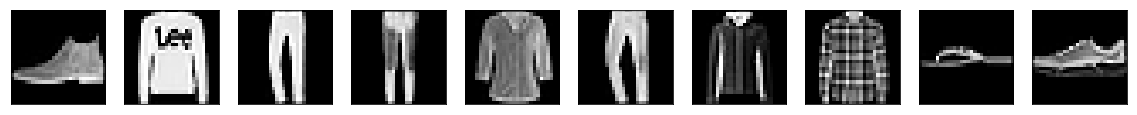

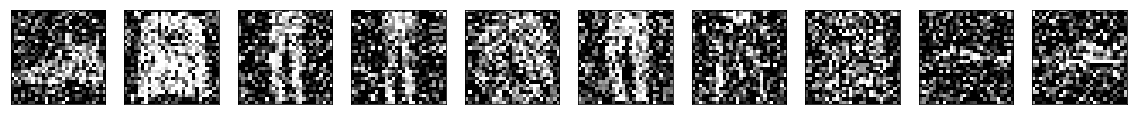

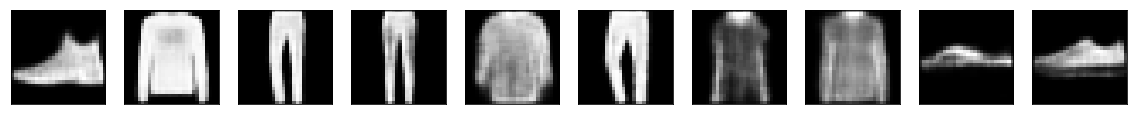

In [19]:
# NOTE: you don't need to change this code, just run it after having trained the DAE
def plot_examples(x):
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(x[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

x_test_reconstr = dae.predict(x_test_noisy, batch_size=batch_size)

plot_examples(x_test)
plot_examples(x_test_noisy)
plot_examples(x_test_reconstr)

**c)** Do you consider the results acceptable? Do you think they can be useful for image retrieval? Explain why in one or two sentences.

**Answer:**

*=== write your answer here ===*

***

**d)** Why can we train on the full dataset `x_train` here, whereas in Tasks 2.1 and 2.2 we had to use `x_train_l` (the first 5 classes only) for training?

**Answer:**

*=== write your answer here ===*

***

### Task 2.4: Fashion neural retrieval #4
Autoencoders come in different shapes and sizes. One key defining property of autoencoders is the means the model uses to prevent the learning of the identity function. Typically, this is done with different regularization methods. In the previous task you used a model that uses noise as a regularizer. In this task you will develop a Sparse Autoencoder (SAE). A sparse autoencoder uses a sparsity regularization to obtain sparse representations of the input data. Sparsity can be achieved by using L1-regularization on the activations of the hidden "code" layer.

**a)** Design a (convolutional) Sparse Autoencoder (SAE) for the *full* Fashion-MNIST dataset (i.e. use `x_train`, *not* `x_train_l`). For the encoder, use only Convolutional layers and Max-Pooling, followed by a Dense layer with 128 units. The output of this layer will be the "code" of the autoencoder (*HINT: you can use* `name="neural_codes"` *for this layer to make it easier to obtain features from it later*). Add an activity regularizer to this layer, using `regularizers.l1(10e-5)` from Keras.
For the decoder, start with a Dense layer to upscale to a suitable dimension, and then use only Convolutional layers and UpSampling. You may use BatchNormalization to speed up training.

Train the SAE to reconstruct input images. Make sure that it achieves a loss value of at most 0.31 on the test set (show this!). Save the trained model to a ".h5" file. (make sure you're using Keras version 2.1.3!)

In [10]:
# import regularizers for sparse autoencoder
from keras import regularizers

In [14]:
# define autoencoder
sae = Sequential()

# encoder
sae.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
sae.add(MaxPooling2D((2, 2), padding='same'))
sae.add(BatchNormalization())
sae.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
sae.add(MaxPooling2D((2, 2), padding='same'))  # at this point the representation is (7, 7, 32)
sae.add(BatchNormalization())
sae.add(Flatten())  # the representation is now a flat vector of dimension 7*7*32 = 1568
sae.add(Dense(128, activation='relu', name="neural_codes", activity_regularizer=regularizers.l1(10e-5)))  # name this "neural_codes" to retrieve as codes later


# decoder
sae.add(Dense(1568))  # obtain representation that can be reshaped to (7, 7, 32)
sae.add(Reshape((7, 7, 32)))
sae.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
sae.add(UpSampling2D((2, 2)))
sae.add(BatchNormalization())
sae.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
sae.add(UpSampling2D((2, 2)))
sae.add(BatchNormalization())
sae.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

sae.summary()
sae.compile(optimizer='adam', loss='binary_crossentropy')

# === SOLUTION: ===
# insert code here
# === SOLUTION: ===
# insert code here

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
flatten_4 (Flatten)          (None, 1568)              0         
__________

In [18]:
batch_size = 100
epochs = 10

sae.fit(x_train_noisy, x_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_split=1/12)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 222s 4ms/step - loss: 0.3951 - val_loss: 0.3779
Epoch 2/10
55000/55000 [==============================] - 219s 4ms/step - loss: 0.3517 - val_loss: 0.3502
Epoch 3/10
55000/55000 [==============================] - 219s 4ms/step - loss: 0.3435 - val_loss: 0.3440
Epoch 4/10
55000/55000 [==============================] - 219s 4ms/step - loss: 0.3379 - val_loss: 0.3367
Epoch 5/10
55000/55000 [==============================] - 219s 4ms/step - loss: 0.3338 - val_loss: 0.3357
Epoch 6/10
55000/55000 [==============================] - 219s 4ms/step - loss: 0.3300 - val_loss: 0.3298
Epoch 7/10
55000/55000 [==============================] - 219s 4ms/step - loss: 0.3263 - val_loss: 0.3269
Epoch 8/10
55000/55000 [==============================] - 221s 4ms/step - loss: 0.3231 - val_loss: 0.3240
Epoch 9/10
55000/55000 [==============================] - 218s 4ms/step - loss: 0.3200 - val_loss: 0.32

In [19]:
test_loss = sae.evaluate(x_test_noisy, x_test, batch_size=batch_size)
print("Test loss:", test_loss)

x_test_reconstr = sae.predict(x_test_noisy, batch_size=batch_size)

10000/10000 [==============================] - 12s 1ms/step
Test loss: 0.31854106813669203


In [20]:
# save the model
sae.save(os.path.join("assignment2_models", "sae_fashionmnist.h5"))

***

**b)** Briefly motivate how and why you chose this architecture.

**Answer:**

*=== write your answer here ===*

***

Visualise a few test examples and their reconstructions.

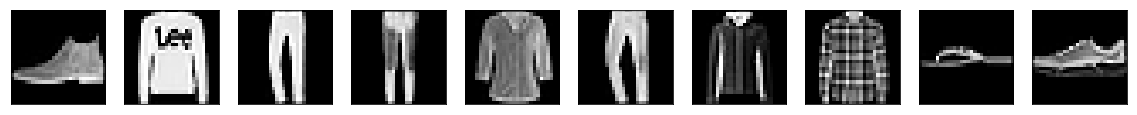

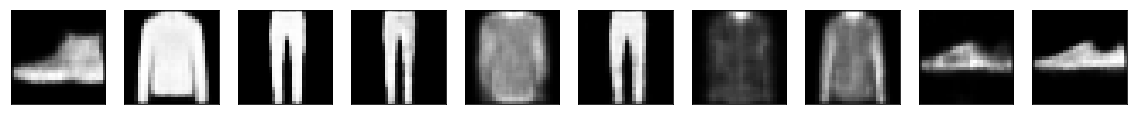

In [21]:
# NOTE: you don't need to change this code, just run it after having trained the SAE
def plot_examples(x):
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(x[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

x_test_reconstr = sae.predict(x_test, batch_size=batch_size)

plot_examples(x_test)
plot_examples(x_test_reconstr)

**c)** Compare the visual results to those of the DAE in Task 2.3. Also compare the loss values of the test set for the DAE and SAE. How can you explain the difference?

**Answer:**

*=== write your answer here ===*

***

### Task 2.5: Comparison
Obtain 128-dimensional neural code representations of the last five classes of the Fashion-MNIST dataset (the *retrieval set*: `x_train_r`) from the following models/layers:
1. The last dense hidden layer (before the output layer) of the MLP you trained in Task 2.1
2. The last dense hidden layer (before the output layer) of the CNN you trained in Task 2.2
3. The center layer/code of the DAE you trained in Task 2.3
4. The center layer/code of the SAE you trained in Task 2.4
5. A PCA-transformation

In [7]:
# additional imports
from keras.models import load_model
from keras.models import Model

In [ ]:
# load the previously trained and saved models
mlp = load_model(os.path.join("assignment2_models", "mlp_fashionmnist_l.h5"))
cnn = load_model(os.path.join("assignment2_models", "cnn_fashionmnist_l.h5"))
dae = load_model(os.path.join("assignment2_models", "dae_fashionmnist.h5"))
sae = load_model(os.path.join("assignment2_models", "sae_fashionmnist.h5"))
    
# NOTE: change the name "neural codes" if the layer from which you wish to retrieve neural codes has a different name
mlp_nc = Model(inputs=mlp.input, outputs=mlp.get_layer("neural_codes_mlp_2").output)
cnn_nc = Model(inputs=cnn.input, outputs=cnn.get_layer("neural_codes_cnn_3").output)
dae_nc = Model(inputs=dae.input, outputs=dae.get_layer("neural_codes").output)
sae_nc = Model(inputs=sae.input, outputs=sae.get_layer("neural_codes").output)

# obtain flat representations of the data
x_train_r_flat = x_train_r.reshape((x_train_r.shape[0], -1))
x_test_r_flat = x_test_r.reshape((x_test_r.shape[0], -1))

# train PCA on the retrieval set
pca = PCA(n_components=128)
pca.fit(x_train_r_flat)

# obtain 128-dimensional representations
nc_mlp_train = mlp_nc.predict(x_train_r)
nc_mlp_test = mlp_nc.predict(x_test_r)
nc_cnn_train = cnn_nc.predict(x_train_r)
nc_cnn_test = cnn_nc.predict(x_test_r)
nc_dae_train = dae_nc.predict(x_train_r)
nc_dae_test = dae_nc.predict(x_test_r)
nc_sae_train = sae_nc.predict(x_train_r)
nc_sae_test = sae_nc.predict(x_test_r)
nc_pca_train = pca.transform(x_train_r_flat)
nc_pca_test = pca.transform(x_test_r_flat)

# print the shapes to confirm all features are 128-dimensional
print(nc_mlp_train.shape)
print(nc_mlp_test.shape)
print(nc_cnn_train.shape)
print(nc_cnn_test.shape)
print(nc_dae_train.shape)
print(nc_dae_test.shape)
print(nc_sae_train.shape)
print(nc_sae_test.shape)
print(nc_pca_train.shape)
print(nc_pca_test.shape)

***

**a)** Evaluate the retrieval task as described in Question 1 on the last 5 classes (the retrieval set) of the Fashion-MNIST dataset, for the five data representations given above. Use query images from the test set and retrieve images from the training set only. Print the five resulting retrieval scores (between 0 and 5).

*HINT: you can use* `y_train_digits_r` *and* `y_test_digits_r` *to obtain digit encodings (as opposed to one-hot encodings) of the data labels.*

In [ ]:
# make random selection of n query images/indices, the same for all experiments
n = 200
n_examples = 5000  # the retrieval test set has 5000 images
indices = np.random.choice(range(n_examples), size=n, replace=False)

representations = [
    (nc_mlp_train, nc_mlp_test),
    (nc_cnn_train, nc_cnn_test),
    (nc_dae_train, nc_dae_test),
    (nc_sae_train, nc_sae_test),
    (nc_pca_train, nc_pca_test),
]
for (nc_train, nc_test) in representations:
    # === SOLUTION: ===
    # insert code here

***

**b)** Compare the "baseline" PCA-transformed data with the other methods. Is PCA a suitable method to obtain representations for image retrieval in this situation? Why do you think so? Would you expect a similar conclusion for the Caltech101 dataset from Question 1?

**Answer:**

*=== write your answer here ===*

***

Observe the difference between encodings from the DAE and SAE.

In [ ]:
print("Mean activation for DAE encodings:", np.mean(nc_dae_train))
print("Mean activation for SAE encodings:", np.mean(nc_sae_train))

index = 1  # try a few indices here
print("DAE encoding example:")
print(nc_dae_train[index])
print("SAE encoding example:")
print(nc_sae_train[index])

**c)** Discuss the difference in encodings between the two autoencoders (denoising and sparse). Also discuss the difference in retrieval performance for these encodings. How would you explain this difference?

**Answer:**

*=== write your answer here ===*

***

**d)** What is the best performing method you found in part a)? Describe what advantage you believe this method has over the others.

**Answer:**

*=== write your answer here ===*

In [2]:
import keras
keras.__version__

c:\users\illia\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.2'